In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [295]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
# torch.cuda.set_device(0)

## Pascal VOC

We will be looking at the [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/) dataset. It's quite slow, so you may prefer to download from [this mirror](https://pjreddie.com/projects/pascal-voc-dataset-mirror/). There are two different competition/research datasets, from 2007 and 2012. We'll be using the 2007 version. You can use the larger 2012 for better results, or even combine them (but be careful to avoid data leakage between the validation sets if you do this).

Unlike previous lessons, we are using the python 3 standard library `pathlib` for our paths and file access. Note that it returns an OS-specific class (on Linux, `PosixPath`) so your output may look a little different. Most libraries than take paths as input can take a pathlib object - although some (like `cv2`) can't, in which case you can use `str()` to convert it to a string.

### Download the dataset

In [5]:
!pwd

/home/ubuntu/fastai/courses/dl2


In [9]:
!ln -s ~/data data

In [12]:
!ls -la data/

total 837144
drwxrwxr-x  4 ubuntu ubuntu      4096 May 20 05:28 .
drwxr-xr-x 24 ubuntu ubuntu      4096 May 20 15:01 ..
drwxrwxr-x  8 ubuntu ubuntu      4096 May 13 13:09 dogscats
-rw-rw-r--  1 ubuntu ubuntu 857214334 Apr  1  2017 dogscats.zip
drwxrwxr-x  2 ubuntu ubuntu      4096 May 20 06:02 spellbee


In [18]:
%cd data

/home/ubuntu/data


In [22]:
%mkdir pascal

In [23]:
%cd pascal/

/home/ubuntu/data/pascal


In [33]:
!tar -xf VOCtrainval_06-Nov-2007.tar

In [20]:
!aria2c --file-allocation=none -c -x 5 -s 5 http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar

[#8be4bd 431MiB/438MiB(98%) CN:1 DL:34MiB]                        
06/15 21:53:04 [NOTICE] Download complete: /home/ubuntu/data/VOCtrainval_06-Nov-2007.tar

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
8be4bd|OK  |    33MiB/s|/home/ubuntu/data/VOCtrainval_06-Nov-2007.tar

Status Legend:
(OK):download completed.


In [21]:
!aria2c --file-allocation=none -c -x 5 -s 5 https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip


06/15 21:54:27 [NOTICE] Download complete: /home/ubuntu/data/PASCAL_VOC.zip

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
1350c8|OK  |   8.4MiB/s|/home/ubuntu/data/PASCAL_VOC.zip

Status Legend:
(OK):download completed.


In [33]:
!tar -xf VOCtrainval_06-Nov-2007.tar

In [35]:
!unzip PASCAL_VOC.zip

Archive:  PASCAL_VOC.zip
   creating: PASCAL_VOC/
  inflating: PASCAL_VOC/pascal_test2007.json  
  inflating: PASCAL_VOC/pascal_train2007.json  
  inflating: PASCAL_VOC/pascal_train2012.json  
  inflating: PASCAL_VOC/pascal_val2007.json  
  inflating: PASCAL_VOC/pascal_val2012.json  


In [36]:
%mv PASCAL_VOC/*.json .

In [38]:
%rmdir PASCAL_VOC

In [39]:
%ls -la

total 462072
drwxrwxr-x 3 ubuntu ubuntu      4096 Jun 15 22:01 ./
drwxrwxr-x 5 ubuntu ubuntu      4096 Jun 15 21:56 ../
-rw-r--r-- 1 ubuntu ubuntu   2584743 Jul  7  2015 pascal_test2007.json
-rw-r--r-- 1 ubuntu ubuntu   1346236 Aug 19  2015 pascal_train2007.json
-rw-r--r-- 1 ubuntu ubuntu   2912167 Aug 19  2015 pascal_train2012.json
-rw-r--r-- 1 ubuntu ubuntu   1342257 Jul  7  2015 pascal_val2007.json
-rw-r--r-- 1 ubuntu ubuntu   2922699 Aug 19  2015 pascal_val2012.json
-rw-rw-r-- 1 ubuntu ubuntu   1998182 Jun 15 21:54 PASCAL_VOC.zip
drwxrwxr-x 3 ubuntu ubuntu      4096 Nov  6  2007 VOCdevkit/
-rw-rw-r-- 1 ubuntu ubuntu 460032000 Jun 15 21:53 VOCtrainval_06-Nov-2007.tar


In [41]:
%cd ~/fastai/courses/dl2

/home/ubuntu/fastai/courses/dl2


In [43]:
PATH = Path('data/pascal')
list(PATH.iterdir())

[PosixPath('data/pascal/pascal_train2012.json'),
 PosixPath('data/pascal/VOCtrainval_06-Nov-2007.tar'),
 PosixPath('data/pascal/pascal_train2007.json'),
 PosixPath('data/pascal/VOCdevkit'),
 PosixPath('data/pascal/pascal_val2007.json'),
 PosixPath('data/pascal/pascal_test2007.json'),
 PosixPath('data/pascal/pascal_val2012.json'),
 PosixPath('data/pascal/PASCAL_VOC.zip')]

As well as the images, there are also *annotations* - *bounding boxes* showing where each object is. These were hand labeled. The original version were in XML, which is a little hard to work with nowadays, so we uses the more recent JSON version which you can download from [this link](https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip).

You can see here how `pathlib` includes the ability to open files (amongst many other capabilities).

In [64]:
trn_j = json.load( (PATH / 'pascal_train2007.json').open() )
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [65]:
IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories']
trn_j[IMAGES][:5]

[{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12},
 {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17},
 {'file_name': '000023.jpg', 'height': 500, 'width': 334, 'id': 23},
 {'file_name': '000026.jpg', 'height': 333, 'width': 500, 'id': 26},
 {'file_name': '000032.jpg', 'height': 281, 'width': 500, 'id': 32}]

In [66]:
trn_j[ANNOTATIONS][:2]

[{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
  'area': 34104,
  'iscrowd': 0,
  'image_id': 12,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0},
 {'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]],
  'area': 13110,
  'iscrowd': 0,
  'image_id': 17,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0}]

In [68]:
trn_j[CATEGORIES][:8]

[{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'},
 {'supercategory': 'none', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'none', 'id': 3, 'name': 'bird'},
 {'supercategory': 'none', 'id': 4, 'name': 'boat'},
 {'supercategory': 'none', 'id': 5, 'name': 'bottle'},
 {'supercategory': 'none', 'id': 6, 'name': 'bus'},
 {'supercategory': 'none', 'id': 7, 'name': 'car'},
 {'supercategory': 'none', 'id': 8, 'name': 'cat'}]

It's helpful to use constants instead of strings, since we get tab-completion and don't mistype.

In [69]:
FILE_NAME, ID, IMG_ID, CAT_ID, BBOX = 'file_name', 'id', 'image_id', 'category_id', 'bbox'

In [75]:
cats = { o[ID]:o["name"] for o in trn_j[CATEGORIES] }
trn_fns = { o[ID]:o[FILE_NAME] for o in trn_j[IMAGES] }
trn_ids = { o[ID] for o in trn_j[IMAGES] }

In [81]:
list( (PATH / 'VOCdevkit/VOC2007').iterdir() )

[PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/SegmentationClass'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/Annotations'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/SegmentationObject'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/ImageSets')]

In [82]:
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'

In [83]:
IMG_PATH = PATH / JPEGS
list( IMG_PATH.iterdir() )[:5]

[PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/001688.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/007189.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/003408.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/001604.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/000729.jpg')]

Each image has a unique ID.

In [84]:
im0_d = trn_j[IMAGES][0]
im0_d

{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12}

In [85]:
im0_d[FILE_NAME], im0_d[ID]

('000012.jpg', 12)

A `defaultdict` is useful any time you want to have a default dictionary entry for new keys. Here we create a dict from image IDs to a list of annotations (tuple of bounding box and class id).

We convert VOC's height/width into top-left/bottom-right, and switch x/y coords to be consistent with numpy.

In [86]:
def hw_bb(bb):
    # Example, bb = [155, 96, 196, 174]
    return np.array([ bb[1], bb[0], bb[3] + bb[1] - 1, bb[2] + bb[0] - 1 ])

In [106]:
# VOC's bbox: column (x coord), row (of top left, y coord), height, width
#ix   0    1   2    3
bb = [155, 96, 196, 174]
bb[1], bb[0], bb[3] + bb[1] - 1, bb[2] + bb[0] - 1

(96, 155, 269, 350)

In [107]:
trn_anno = collections.defaultdict(lambda:[])

for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX] # one bbox. looks like '[155, 96, 196, 174]'.
        bb = hw_bb(bb)
        trn_anno[o[IMG_ID]].append( (bb, o[CAT_ID]) )

len(trn_anno)

2501

In [115]:
# Test getting the first element from dict_values
list(trn_anno.values())[0]

[(array([ 96, 155, 269, 350]), 7)]

In [117]:
print(im0_d[ID])

im_a = trn_anno[im0_d[ID]]
im_a

12


[(array([ 96, 155, 269, 350]), 7)]

In [120]:
im0_a = im_a[0] # get first item (first bbox) from list. note: possible to have more than one bbox per image.
im0_a

(array([ 96, 155, 269, 350]), 7)

In [121]:
cats[7]

'car'

In [122]:
trn_anno[17]

[(array([ 61, 184, 198, 278]), 15), (array([ 77,  89, 335, 402]), 13)]

In [123]:
cats[15], cats[13]

('person', 'horse')

Some libs take VOC format bounding boxes, so this let's us convert back when required:

In [124]:
bb_voc = [155, 96, 196, 174]
bb_fastai = hw_bb(bb_voc)
bb_fastai

array([ 96, 155, 269, 350])

In [125]:
def bb_hw(a):
    return np.array( [ a[1], a[0], a[3] - a[1] + 1, a[2] - a[0] + 1 ] )

In [126]:
f'expected: {bb_voc}, actual: {bb_hw(bb_fastai)}'

'expected: [155, 96, 196, 174], actual: [155  96 196 174]'

You can use [Visual Studio Code](https://code.visualstudio.com/) (vscode - open source editor that comes with recent versions of Anaconda, or can be installed separately), or most editors and IDEs, to find out all about the `open_image` function. vscode things to know:

- Command palette (<kbd>Ctrl-shift-p</kbd>)
- Select interpreter (for fastai env)
- Select terminal shell
- Go to symbol (<kbd>Ctrl-t</kbd>)
- Find references (<kbd>Shift-F12</kbd>)
- Go to definition (<kbd>F12</kbd>)
- Go back (<kbd>alt-left</kbd>)
- View documentation
- Hide sidebar (<kbd>Ctrl-b</kbd>)
- Zen mode (<kbd>Ctrl-k,z</kbd>)

In [127]:
im = open_image(IMG_PATH / im0_d[FILE_NAME])

Matplotlib's `plt.subplots` is a really useful wrapper for creating plots, regardless of whether you have more than one subplot. Note that Matplotlib has an optional object-oriented API which I think is much easier to understand and use (although few examples online use it!)

In [135]:
def show_img(im, figsize=None, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

A simple but rarely used trick to making text visible regardless of background is to use white text with black outline, or visa versa. Here's how to do it in matplotlib.

In [140]:
def draw_outline(o, lw):
    o.set_path_effects( [patheffects.Stroke(linewidth=lw, foreground='black'),
                          patheffects.Normal()] )

Note that `*` in argument lists is the [splat operator](https://stackoverflow.com/questions/5239856/foggy-on-asterisk-in-python). In this case it's a little shortcut compared to writing out `b[-2],b[-1]`.

In [130]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [330]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt, verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

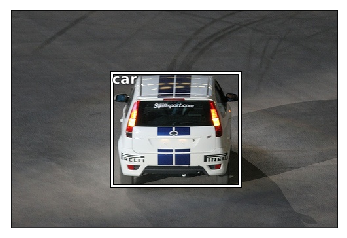

In [142]:
ax = show_img(im)
b = bb_hw(im0_a[0]) # convert bbox back to VOC format
draw_rect(ax, b)
draw_text(ax, b[:2], cats[im0_a[1]])

### Packaging it all up

In [143]:
def draw_im(im, ann):
    # im is image, ann is annotations
    ax = show_img(im, figsize=(16, 8))
    for b, c in ann:
        # b is bbox, c is class id
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

In [146]:
def draw_idx(i):
    # i is image id
    im_a = trn_anno[i] # training annotations
    im = open_image(IMG_PATH / trn_fns[i]) # trn_fns is training image file names
    print(im.shape)
    draw_im(im, im_a) # im_a is an element of annotation

(364, 480, 3)


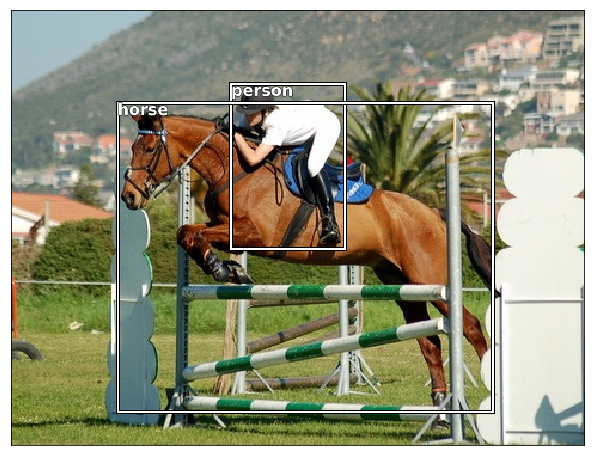

In [147]:
draw_idx(17) # image id is 17

## Largest item classifier

A *lambda function* is simply a way to define an anonymous function inline. Here we use it to describe how to sort the annotation for each image - by bounding box size (descending).

In [244]:
def get_lrg(b):
    if not b:
        raise Exception()
    # x is tuple. e.g.: (array([96 155 269 350]), 16)
    # x[0] returns a numpy array. e.g.: [96 155 269 350]
    # x[0][-2:] returns a numpy array. e.g.: [269 350]. This is the width x height of a bbox.
    # x[0][:2] returns a numpy array. e.g.: [96 155]. This is the x/y coord of a bbox.
    # np.product(x[0][-2:] - x[0][:2]) returns a scalar. e.g.: 33735
    b = sorted(b, key=lambda x: np.product(x[0][-2:] - x[0][:2]), reverse=True)
    return b[0] # get the first element in the list, which is the largest bbox for one image.

In [240]:
# Debugging codes
np_prod = np.product(np.array([269, 350]) - np.array([96, 155]))
minus_mul = (269 - 96) * (350 - 155) # bbox volume (area): width x height at origin (0, 0)
print(np_prod)
assert np_prod == minus_mul

33735


In [ ]:
# for k, v in trn_anno.items():
#     print(f"k: {k}, v: {v}")

In [242]:
# a is image id (int), b is tuple of bbox (numpy array) & class id (int)
trn_lrg_anno = { a: get_lrg(b) for a, b in trn_anno.items() if (a != 0 and a != 1) }

In [263]:
trn_lrg_anno[23]

(array([  1,   2, 461, 242]), 15)

Now we have a dictionary from image id to a single bounding box - the largest for that image.

In [259]:
def draw_largest_bbox(img_id):
    b, c = trn_lrg_anno[img_id] # trn_lrg_anno is a tuple. destructuring syntax.
    print(f'### DEBUG ### bbox: {b.tolist()}, class id: {c}') # print numpy.ndarray using tolist method.

    b = bb_hw(b) # convert back fastai's bbox to VOC format
    ax = show_img(open_image(IMG_PATH / trn_fns[img_id]), figsize=(5, 10))
    draw_rect(ax, b)
    draw_text(ax, b[:2], cats[c], sz=16)

### DEBUG ### bbox: [125, 108, 365, 414], class id: 13


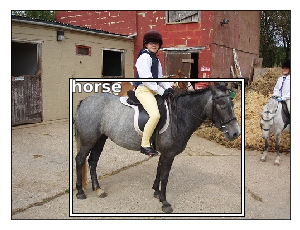

In [283]:
img_id = 695
draw_largest_bbox(img_id)

In [273]:
(PATH / 'tmp').mkdir(exist_ok=True)
CSV = PATH / 'tmp/lrg.csv'

Often it's easiest to simply create a CSV of the data you want to model, rather than trying to create a custom dataset. Here we use Pandas to help us create a CSV of the image filename and class.

In [274]:
df = pd.DataFrame({ 'fn': [trn_fns[o] for o in trn_ids],
                    'cat': [cats[trn_lrg_anno[o][1]] for o in trn_ids] }, columns=['fn', 'cat'])
df.to_csv(CSV, index=False)

In [284]:
f_model = resnet34
sz = 224
bs = 64

From here it's just like Dogs vs Cats!

In [285]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms, bs=bs)

In [288]:
x, y = next(iter(md.val_dl))

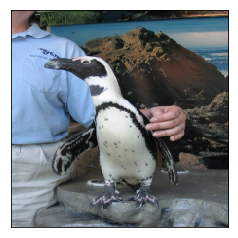

In [291]:
show_img(md.val_ds.denorm(to_np(x))[0])

In [296]:
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])

In [297]:
learn.opt_fn = optim.Adam

In [298]:
lrf = learn.lr_find(1e-5, 100)

 78%|███████▊  | 25/32 [00:11<00:03,  2.09it/s, loss=13.1]

When your LR finder graph looks like this, you can ask for more points on each end:

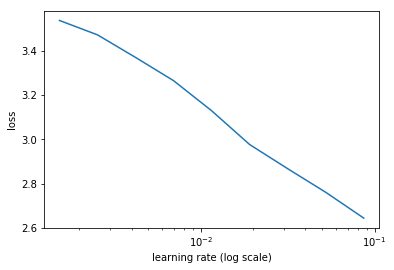

In [299]:
learn.sched.plot()

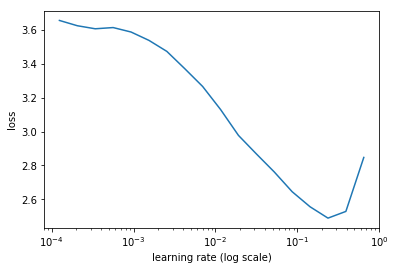

In [300]:
learn.sched.plot(n_skip=5, n_skip_end=1)

In [301]:
lr = 2e-2

In [302]:
learn.fit(lr, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                 
    0      1.259122   0.782595   0.78      


[array([0.78259]), 0.779999997138977]

In [303]:
lrs = np.array([lr/1000, lr/100, lr])

In [304]:
learn.freeze_to(-2)

 84%|████████▍ | 27/32 [00:17<00:03,  1.52it/s, loss=5.12] 

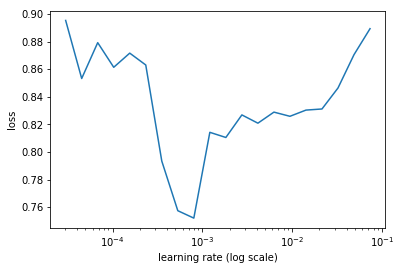

In [305]:
lrf = learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [306]:
learn.fit(lrs/5, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.789873   0.674313   0.788     


[array([0.67431]), 0.7879999985694885]

In [307]:
learn.unfreeze()

Accuracy isn't improving much - since many images have multiple different objects, it's going to be impossible to be that accurate.

In [308]:
learn.fit(lrs/5, 1, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.600366   0.672303   0.794     
    1      0.444746   0.691367   0.786                     


[array([0.69137]), 0.786]

In [309]:
learn.save('clas_one')

In [310]:
learn.load('clas_one')

In [311]:
x, y = next(iter(md.val_dl))
probs = F.softmax(predict_batch(learn.model, x), -1)
x, preds = to_np(x), to_np(probs)
preds = np.argmax(preds, -1)

You can use the python debugger `pdb` to step through code.

- `pdb.set_trace()` to set a breakpoint
- `%debug` magic to trace an error

Commands you need to know:

- s / n / c
- u / d
- p
- l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


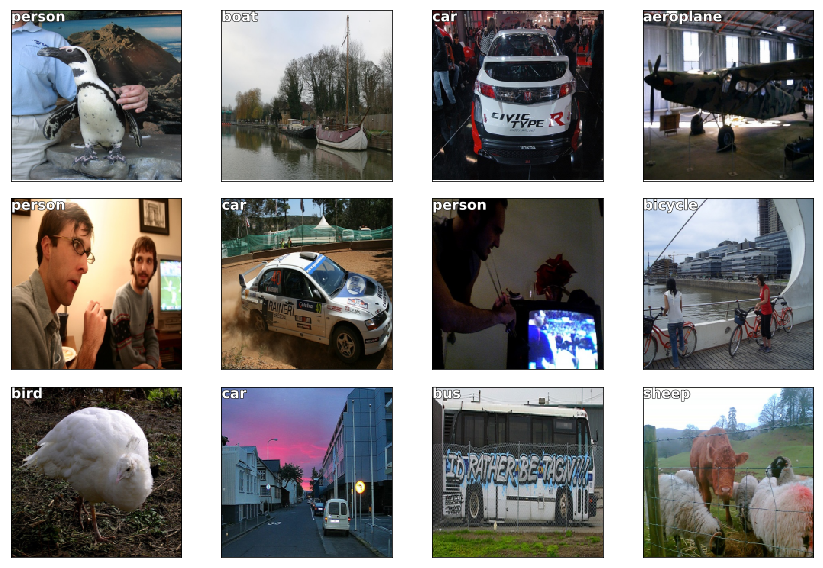

In [331]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    ima = md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0, 0), b)

plt.tight_layout()

It's doing a pretty good job of classifying the largest object!

## Bbox only

Now we'll try to find the bounding box of the largest object. This is simply a regression with 4 outputs. So we can use a CSV with multiple 'labels'.

In [332]:
BB_CSV = PATH / 'tmp/bb.csv'

In [333]:
bb = np.array([ trn_lrg_anno[o][0] for o in trn_ids ])
bbs = [' '.join( str(p) for p in o ) for o in bb]

df = pd.DataFrame({
    'fn': [ trn_fns[o] for o in trn_ids ],
    'bbox': bbs
}, columns=['fn', 'bbox'])
df.to_csv(BB_CSV, index=False)

In [334]:
BB_CSV.open().readlines()[:5] # read up to 5 lines

['fn,bbox\n',
 '008197.jpg,186 450 226 496\n',
 '008199.jpg,84 363 374 498\n',
 '008202.jpg,110 190 371 457\n',
 '008203.jpg,187 37 359 303\n']

In [335]:
f_model = resnet34
sz = 224
bs = 64

Set `continuous=True` to tell fastai this is a regression problem, which means it won't one-hot encode the labels, and will use MSE as the default crit.

Note that we have to tell the transforms constructor that our labels are coordinates, so that it can handle the transforms correctly.

Also, we use CropType.NO because we want to 'squish' the rectangular images into squares, rather than center cropping, so that we don't accidentally crop out some of the objects. (This is less of an issue in something like imagenet, where there is a single object to classify, and it's generally large and centrally located).

In [336]:
augs = [RandomFlip(),
        RandomRotate(30),
        RandomLighting(0.1,0.1)]

In [340]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True, bs=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


b: [  1.  89. 499. 192.]
b: [  1.  89. 499. 192.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


b: [  1.  89. 499. 192.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


b: [  1.  89. 499. 192.]
b: [  1.  89. 499. 192.]
b: [  1.  89. 499. 192.]
b: [  1.  89. 499. 192.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


b: [  1.  89. 499. 192.]
b: [  1.  89. 499. 192.]


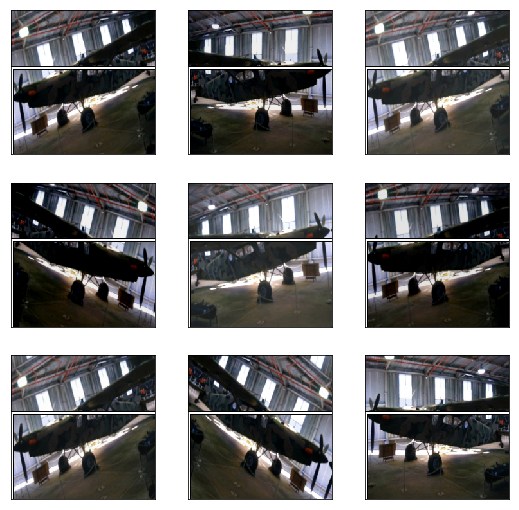

In [341]:
idx = 3
fig, axes = plt.subplots(3, 3, figsize=(9, 9))

for i, ax in enumerate(axes.flat):
    x, y = next(iter(md.aug_dl))
    ima = md.val_ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    print('b:', b)
    show_img(ima, ax=ax)
    draw_rect(ax, b)

In [342]:
augs = [RandomFlip(tfm_y=TfmType.COORD),
        RandomRotate(30, tfm_y=TfmType.COORD),
        RandomLighting(0.1,0.1, tfm_y=TfmType.COORD)]

In [343]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, aug_tfms=augs, tfm_y=TfmType.COORD)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True, bs=4)

[  1.  60. 221. 125.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[  0.  12. 224. 211.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[  0.   9. 224. 214.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[  0.  21. 224. 202.]
[  0.   0. 224. 223.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[  0.  55. 224. 135.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[  0.  15. 224. 208.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[  0.  31. 224. 182.]
[  0.  53. 224. 139.]


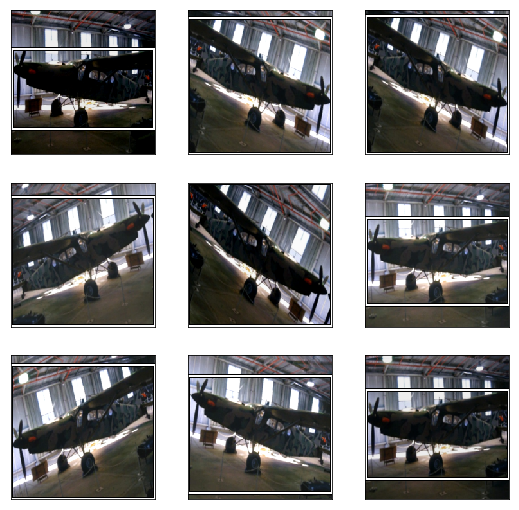

In [344]:
idx = 3
fig, axes = plt.subplots(3, 3, figsize=(9, 9))

for i, ax in enumerate(axes.flat):
    x, y = next(iter(md.aug_dl))
    ima = md.val_ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, b)

In [346]:
tfm_y = TfmType.COORD
augs = [RandomFlip(tfm_y=tfm_y),
        RandomRotate(3, p=0.5, tfm_y=tfm_y),
        RandomLighting(0.05,0.05, tfm_y=tfm_y)]

tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=tfm_y, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, bs=bs, continuous=True)

fastai let's you use a `custom_head` to add your own module on top of a convnet, instead of the adaptive pooling and fully connected net which is added by default. In this case, we don't want to do any pooling, since we need to know the activations of each grid cell.

The final layer has 4 activations, one per bounding box coordinate. Our target is continuous, not categorical, so the MSE loss function used does not do any sigmoid or softmax to the module outputs.

In [66]:
512*7*7

25088

In [348]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(512*7*7, 4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

In [349]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

 78%|███████▊  | 25/32 [00:11<00:03,  2.14it/s, loss=529] 

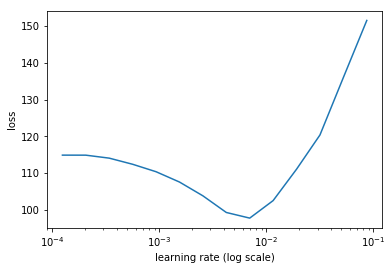

In [350]:
learn.lr_find(1e-5, 100)
learn.sched.plot(5)

In [351]:
lr = 2e-3

In [352]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                            
    0      48.960351  35.755788 
    1      37.135304  29.60765                            
    2      31.466736  29.009163                           


[array([29.00916])]

In [353]:
lrs = np.array([lr/100, lr/10, lr])

In [354]:
learn.freeze_to(-2)

epoch      trn_loss   val_loss                            
    0      82.31227   1.4744848065204166e+17


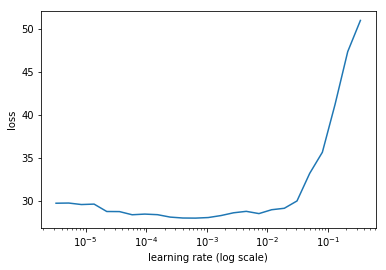

In [355]:
lrf = learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [356]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                            
    0      25.858838  25.091344 
    1      22.565964  22.855172                           
    2      19.391733  21.236308                           


[array([21.23631])]

In [357]:
learn.freeze_to(-3)

In [358]:
learn.fit(lrs, 1, cycle_len=2)

epoch      trn_loss   val_loss                            
    0      18.009395  21.977178 
    1      16.113632  20.927288                           


[array([20.92729])]

In [360]:
learn.save('reg4')

In [361]:
learn.load('reg4')

### Let's see how our model did

In [362]:
x, y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


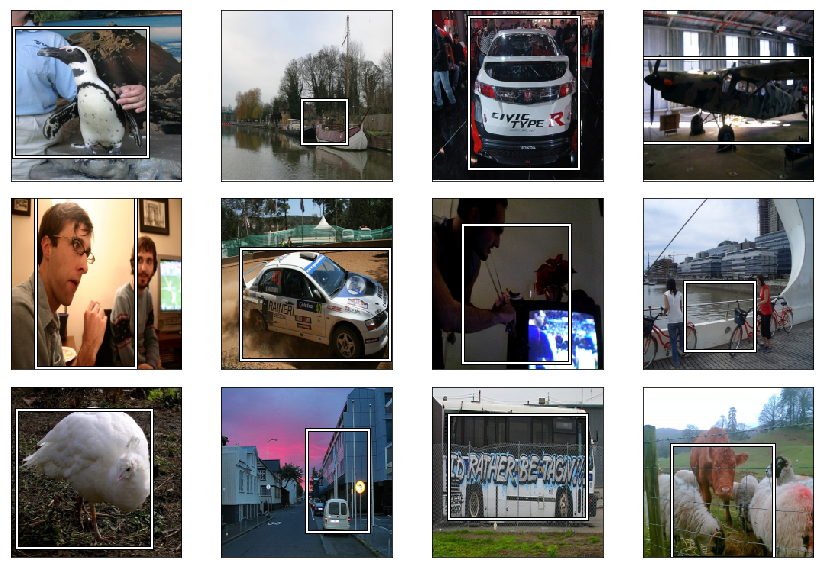

In [363]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    ima = md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()

## Single object detection

In [67]:
f_model=resnet34
sz=224
bs=64

val_idxs = get_cv_idxs(len(trn_fns))

In [80]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms,
   bs=bs, continuous=True, val_idxs=val_idxs)

In [81]:
md2 = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms_from_model(f_model, sz))

A dataset can be anything with `__len__` and `__getitem__`. Here's a dataset that adds a 2nd label to an existing dataset:

In [82]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): self.ds,self.y2 = ds,y2
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

We'll use it to add the classes to the bounding boxes labels.

In [83]:
trn_ds2 = ConcatLblDataset(md.trn_ds, md2.trn_y)
val_ds2 = ConcatLblDataset(md.val_ds, md2.val_y)

In [84]:
val_ds2[0][1]

(array([   0.,   49.,  205.,  180.], dtype=float32), 14)

We can replace the dataloaders' datasets with these new ones.

In [85]:
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

We have to `denorm`alize the images from the dataloader before they can be plotted.

In [86]:
x,y=next(iter(md.val_dl))
idx=3
ima=md.val_ds.ds.denorm(to_np(x))[idx]
b = bb_hw(to_np(y[0][idx])); b

array([  52.,   38.,  106.,  184.], dtype=float32)

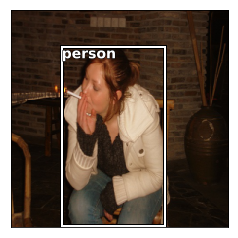

In [87]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], md2.classes[y[1][idx]])

We need one output activation for each class (for its probability) plus one for each bounding box coordinate. We'll use an extra linear layer this time, plus some dropout, to help us train a more flexible model.

In [88]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(cats)),
)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [89]:
def detn_loss(input, target):
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*224
    # I looked at these quantities separately first then picked a multiplier
    #   to make them approximately equal
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

A Jupyter Widget

 97%|█████████▋| 31/32 [00:07<00:00,  4.32it/s, loss=920]


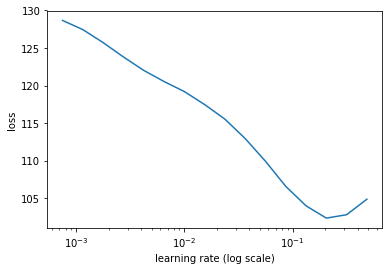

In [171]:
learn.lr_find()
learn.sched.plot()

In [90]:
lr=1e-2

In [51]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

A Jupyter Widget

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      72.036466  45.186367  0.802133   32.647586 
    1      51.037587  36.34964   0.828425   25.389733     
    2      41.4235    35.292709  0.835637   24.343577     



[35.292709, 0.83563701808452606, 24.343576669692993]

In [52]:
learn.save('reg1_0')

In [53]:
learn.freeze_to(-2)

In [54]:
lrs = np.array([lr/100, lr/10, lr])

A Jupyter Widget

 91%|█████████ | 29/32 [00:09<00:01,  2.99it/s, loss=308] 


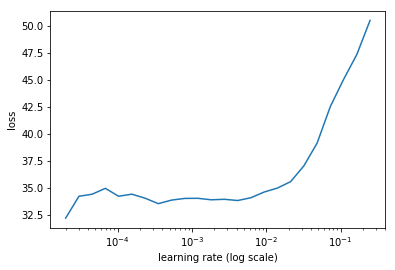

In [185]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [55]:
learn.fit(lrs/5, 1, cycle_len=5, use_clr=(32,10))

A Jupyter Widget

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      34.448113  35.972973  0.801683   22.918499 
    1      28.889909  33.010857  0.830379   21.689888     
    2      24.237017  30.977512  0.81881    20.817996     
    3      21.132993  30.60677   0.83143    20.138552     
    4      18.622983  30.54178   0.825571   19.832196     



[30.54178, 0.82557091116905212, 19.832195997238159]

In [56]:
learn.save('reg1_1')

In [353]:
learn.load('reg1_1')

In [57]:
learn.unfreeze()

In [58]:
learn.fit(lrs/10, 1, cycle_len=10, use_clr=(32,10))

A Jupyter Widget

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      15.957164  31.111507  0.811448   19.970753 
    1      15.955259  32.597153  0.81235    20.111022     
    2      15.648723  32.231941  0.804087   19.522853     
    3      14.876172  30.93821   0.815805   19.226574     
    4      14.113872  31.03952   0.808594   19.155093     
    5      13.293885  29.736671  0.826022   18.761728     
    6      12.562566  30.000023  0.827524   18.82006      
    7      11.885125  30.28841   0.82512    18.904158     
    8      11.498326  30.070133  0.819712   18.635296     
    9      11.015841  30.213772  0.815805   18.551489     



[30.213772, 0.81580528616905212, 18.551488876342773]

In [59]:
learn.save('reg1')

In [108]:
learn.load('reg1')

In [60]:
y = learn.predict()
x,_ = next(iter(md.val_dl))

In [61]:
from scipy.special import expit

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


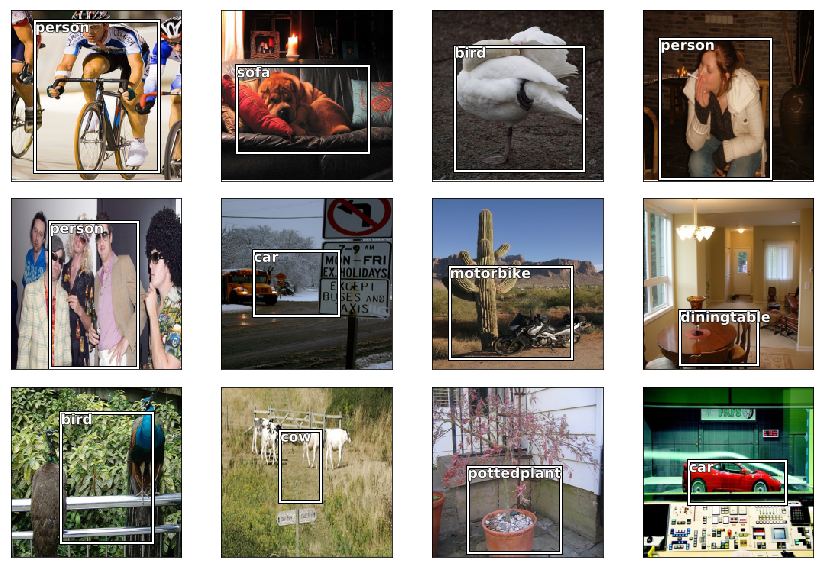

In [62]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(to_np(x))[i]
    bb = expit(y[i][:4])*224
    b = bb_hw(bb)
    c = np.argmax(y[i][4:])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
    draw_text(ax, b[:2], md2.classes[c])
plt.tight_layout()

## End